# Exercise 12.3
## Discriminative localization  (CAM)
In this exercise we will create class activation maps (CAMs) for predictions made by a model trained to classify magentic phases (see [Exercise 7_1](Exercise_7_1_solution.ipynb)).
 1. Pick out two correctly and two wrongly classified images classified with a convolutional network.
 2. Look at Exercise 8.1 to extract weights and feature maps from the trained network model.
 3. Create and plot the class activation maps and compare them with the images in order to see which regions lead to the prediction.


In [3]:
from tensorflow import keras
import numpy as np
callbacks = keras.callbacks
layers = keras.layers

print("keras", keras.__version__)

keras 2.4.0


### Load and prepare dataset
See https://doi.org/10.1038/nphys4035 for more information

In [4]:
import gdown
url = "https://drive.google.com/u/0/uc?export=download&confirm=HgGH&id=1Ihxt1hb3Kyv0IrjHlsYb9x9QY7l7n2Sl"
output = 'ising_data.npz'
gdown.download(url, output, quiet=True)

f = np.load(output)
n_train = 20000

x_train, x_test = f["C"][:n_train], f["C"][n_train:]
T_train, T_test = f["T"][:n_train], f["T"][n_train:]

Tc = 2.27
y_train = np.zeros_like(T_train)
y_train[T_train > Tc] = 1
y_train = keras.utils.to_categorical(y_train, 2)

y_test = np.zeros_like(T_test)
y_test[T_test > Tc] = 1
y_test = keras.utils.to_categorical(y_test, 2)

### Plot data

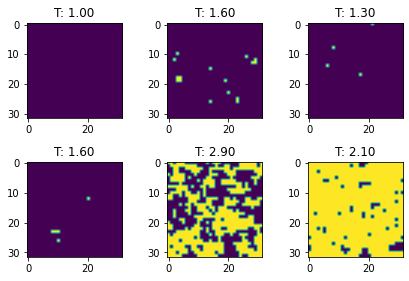

In [5]:
import matplotlib.pyplot as plt

for i,j in enumerate(np.random.choice(n_train, 6)):
    plt.subplot(2,3,i+1)
    image = x_train[j]
    plot = plt.imshow(image)
    plt.title("T: %.2f" % T_train[j])

plt.tight_layout()
plt.show()

### Definition of the model

Define a CNN for discriminative localization. Note that the CNN must use `GlobalAveragePooling2D` after the convolutional part and must not feature more than a single fully-connected layer as output.

In [6]:
model = keras.models.Sequential()
model.add(layers.InputLayer(input_shape=(32, 32)))
model.add(layers.Reshape((32, 32,1)))
model.add(layers.Convolution2D(16, (3, 3), padding='same', activation='relu'))
model.add(layers.Convolution2D(16, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.25))
model.add(layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0

### prepare model for training

In [8]:
model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(0.001),
    metrics=['accuracy'])

In [9]:
results = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=50,
                    verbose=2,
                    validation_split=0.1,
                    callbacks=[
                        callbacks.EarlyStopping(patience=5, verbose=1),
                        callbacks.ReduceLROnPlateau(factor=0.67, patience=2, verbose=1)]
                    )

Epoch 1/50
282/282 - 10s - loss: 0.1006 - accuracy: 0.9611 - val_loss: 0.0612 - val_accuracy: 0.9750
Epoch 2/50
282/282 - 14s - loss: 0.0476 - accuracy: 0.9814 - val_loss: 0.0415 - val_accuracy: 0.9825
Epoch 3/50
282/282 - 23s - loss: 0.0464 - accuracy: 0.9810 - val_loss: 0.0555 - val_accuracy: 0.9785
Epoch 4/50
282/282 - 24s - loss: 0.0480 - accuracy: 0.9804 - val_loss: 0.0364 - val_accuracy: 0.9845
Epoch 5/50
282/282 - 24s - loss: 0.0465 - accuracy: 0.9809 - val_loss: 0.0379 - val_accuracy: 0.9840
Epoch 6/50
282/282 - 25s - loss: 0.0443 - accuracy: 0.9811 - val_loss: 0.0435 - val_accuracy: 0.9835

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0006700000318232924.
Epoch 7/50
282/282 - 23s - loss: 0.0421 - accuracy: 0.9832 - val_loss: 0.0377 - val_accuracy: 0.9840
Epoch 8/50
282/282 - 25s - loss: 0.0424 - accuracy: 0.9823 - val_loss: 0.0388 - val_accuracy: 0.9835

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0004489000252215192.
Epoch 9/50
282/282 - 25s - los

### Evaluate training

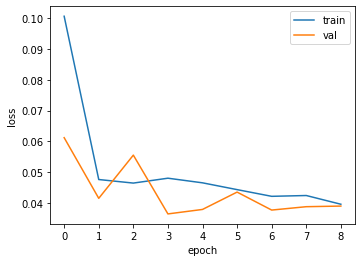

In [10]:
plt.figure(1, (12, 4))
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

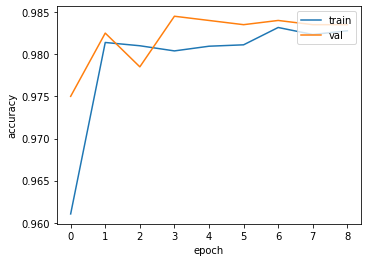

In [11]:
plt.figure(1, (12, 4))
plt.subplot(1, 2, 1)
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

## Create class activation maps

#### Task
Look at Exercise 8.1 to extract weights and feature maps from the trained network model.  

First, extract the activations of the last convolutional layer.

In [ ]:
conv = model.layers[-4]  # last conv layer

Then, create the class activation maps by omitting the global average pooling operation and applying the weights of the single classification layer to the extracted activations.

### Plot the class activation maps for examples just below and above the critical temperature

#### Task
Plot the CAMs for wrongly and correctly classified images.  

Note, you can use `interpolation='bilinear` in `plt.imshow` to upsample the CAMs.